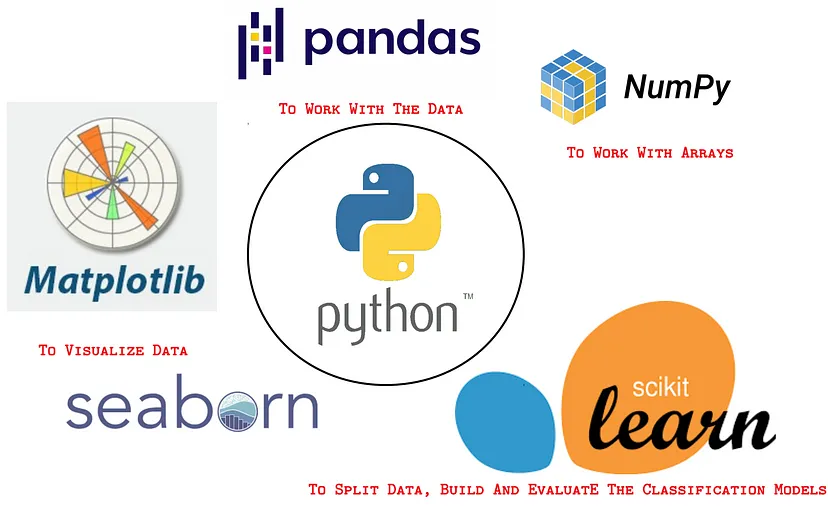

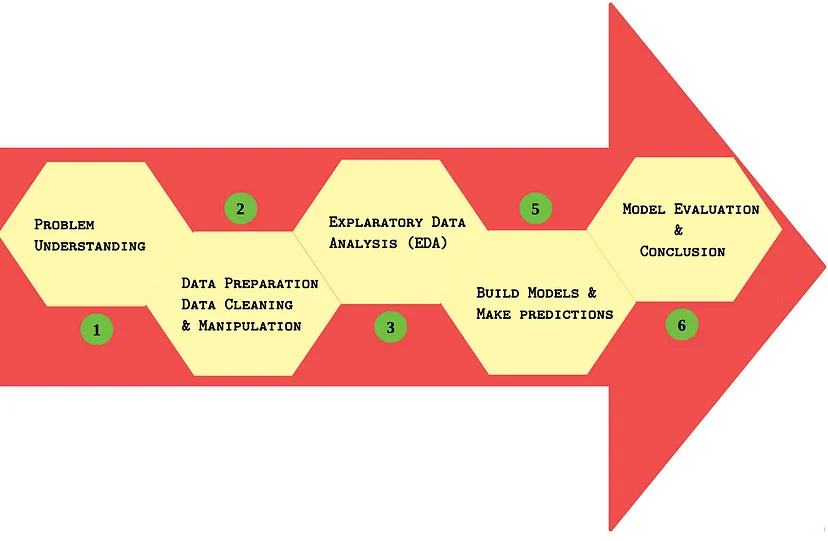

In [42]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from sklearn import preprocessing

from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


%matplotlib inline

In [8]:
application_df = pd.read_csv('application_record_updated_v1.csv')

### <span style="color:#FF00FF">Data Preparation</span>

In [9]:
print(application_df.shape)

(438557, 22)


In [10]:
columns={'CODE_GENDER':'Gender',
         'FLAG_OWN_CAR':'Own Car',
         'FLAG_OWN_REALTY':'Own Realty',
         'CNT_CHILDREN':'Children Count',
         'AMT_INCOME_TOTAL':'Annual Income',
         'NAME_INCOME_TYPE': 'Income Type',
         'NAME_EDUCATION_TYPE':'Education',
         'NAME_FAMILY_STATUS':'Family Status',
         'NAME_HOUSING_TYPE':'Housing Type',
         'DAYS_BIRTH': 'Days Birth',
         'DAYS_EMPLOYED': 'Days Employed',
         'FLAG_MOBIL': 'Flag Mobile',
         'FLAG_PHONE': 'Flag Phone',
         'FLAG_WORK_PHONE': 'Flag Work Phone',
         'FLAG_EMAIL': 'Flag Email',
         'OCCUPATION_TYPE': 'Occupation Type',
         'CNT_FAM_MEMBERS': 'Family Members Count'
         }
application_df.rename(columns=columns,inplace=True)

* **ID**: Application ID
* **Gender**: Gender of the applicant (M: Male, F: Female)
* **Own Car**: Flag indicating if the applicant owns a car (Y: Yes, N: No)
* **Own Realty**: Flag indicating if the applicant owns realty (Y: Yes, N: No)
* **Children Count**: Number of children
* **Annual Income**: Monthly income of the applicant
* **Income Type**: Type of income (e.g., Working, Pensioner)
* **Education**: Highest level of education
* **Family Status**: Family status of the applicant
* **Housing Type**: Type of housing situation
* **Days Birth**: Age of the applicant in days (negative value)
* **Days Employed**: Number of days employed (negative value for unemployed)
* **Flag Mobile**: Flag indicating if a mobile phone is reachable (1: Yes, 0: No)
* **Flag Work Phone**: Flag indicating if the applicant has a work phone (1: Yes, 0: No)
* **Flag Phone**: Flag indicating if the applicant has a phone (1: Yes, 0: No)
* **Flag Email**: Flag indicating if the applicant has an email (1: Yes, 0: No)
* **Occupation Type**: Occupation of the applicant
* **Family Members Count**: Number of family members
* **Approval Status**: Approval status of the credit application (Approved or Rejected)
* **Rejection Reasons**: Reasons for rejection (available only for rejected applications)
* **Credit Score**: Credit score of the applicant
* **Credit Status**: Credit status of the applicant

In [11]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     438557 non-null  int64  
 1   Gender                 438557 non-null  object 
 2   Own Car                438557 non-null  object 
 3   Own Realty             438557 non-null  object 
 4   Children Count         438557 non-null  int64  
 5   Annual Income          438557 non-null  float64
 6   Income Type            438557 non-null  object 
 7   Education              438557 non-null  object 
 8   Family Status          438557 non-null  object 
 9   Housing Type           438557 non-null  object 
 10  Days Birth             438557 non-null  int64  
 11  Days Employed          438557 non-null  int64  
 12  Flag Mobile            438557 non-null  int64  
 13  Flag Work Phone        438557 non-null  int64  
 14  Flag Phone             438557 non-nu

In [12]:
#check that the total null values in each column
application_df.isnull().sum()

ID                            0
Gender                        0
Own Car                       0
Own Realty                    0
Children Count                0
Annual Income                 0
Income Type                   0
Education                     0
Family Status                 0
Housing Type                  0
Days Birth                    0
Days Employed                 0
Flag Mobile                   0
Flag Work Phone               0
Flag Phone                    0
Flag Email                    0
Occupation Type          134203
Family Members Count          0
Approval Status               0
Reason for Rejection     348814
Credit Score                  0
Credit Score Category         0
dtype: int64

<AxesSubplot:>

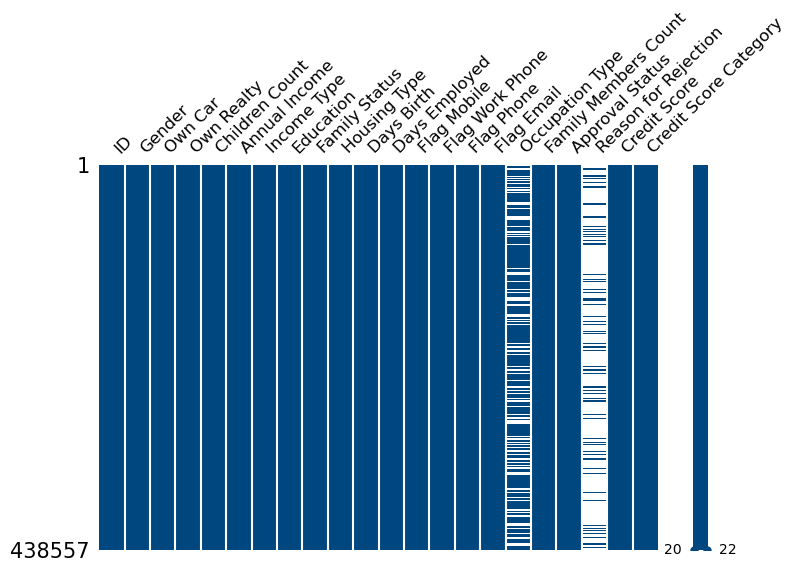

In [13]:
# visualizing distribution of missing values using missingno library
msno.matrix(application_df, color=(0, 0.28, 0.5), figsize=(8,5), fontsize=12)

OCCUPATION_TYPE: is the client's field of work, and it could be in any work staff, whether technical, real estate, or human resources

so some of these values can be filled with a value of "UN_EMPLOYEED" if the customer's working days are a positive number which means that he has never worked.

In [14]:
application_df['Occupation Type'].fillna(value='Other', inplace=True)

In [15]:
# Drop Duplicates
application = application_df.drop_duplicates(subset=application_df.columns[1:], keep='first')

In [16]:
# Create unemployed indicator
application_df['Unemployed']=0
application_df.loc[-application_df['Days Employed']<0,'Unemployed']=1

# Create years employed feature
application_df['Years Employed']=-application_df['Days Employed']/365
application_df.loc[application_df['Years Employed']<0,'Years Employed']=0

# Converting days of birth to age in years
application_df['Age'] = -application_df['Days Birth'] // 365

In [17]:
application_df.drop( columns = ['Days Birth'],inplace=True)
application_df.drop( columns = ['Days Employed'],inplace=True)

In [18]:
application_df.head()

,ID,Gender,Own Car,Own Realty,Children Count,Annual Income,Income Type,Education,Family Status,Housing Type,...,Flag Email,Occupation Type,Family Members Count,Approval Status,Reason for Rejection,Credit Score,Credit Score Category,Unemployed,Years Employed,Age
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,Other,2,Approved,NaN,716,Fair,0,12.443836,32
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,Other,2,Approved,NaN,740,Fair,0,12.443836,32
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Security staff,2,Approved,NaN,710,Fair,0,3.106849,58
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,Sales staff,1,Approved,NaN,789,Good,0,8.358904,52
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,Sales staff,1,Approved,NaN,731,Fair,0,8.358904,52
